<a href="https://colab.research.google.com/github/center4ml/Workshops/blob/2023_2/Day_2/20_PINN-ODE-forward_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-informed neural network (PINN) demo

In this demo we will code a PINN from scratch in `PyTorch` and use it to solve **forward problems** related to the damped harmonic oscillator.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CUDA support
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = 'cpu'
print(f"device is set to: {device}")

device is set to: cpu


## Inspiration & Acknoledgments

This notebook follows lab exercise from [ETH Zürich Deep Learning in Scientific Computing Master's course 2023](https://github.com/benmoseley/DLSC-2023/tree/main).

Readings (blog post) ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).


## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="https://github.com/center4ml/Workshops/blob/2023_2/Day_2/oscillator.gif?raw=1" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above).

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


For this task, we use $\delta=2$, $\omega_0=20$, $m=1$, and try to learn the solution over the domain $t\in [0,1]$.


For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

There are **three scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will learn the system using a normal NN, and **traing data**.

>Second, we will learn the system using a PINN, given its initial conditions and **known ODE without training data**.

>Third, we will **invert** for underlying parameters of the system using a PINN, given some noisy observations of the oscillator's displacement.

## Initial setup

Let us define a few helper functions.

In [3]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u


class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


In [4]:
# PDE coefficients
d, w0 = 2, 20
mu, k = 2*d, w0**2

# reference solution (to plot)
t_exact = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_exact)


def make_plot(t_training_locations, u_training_locations, u_predicted, label_text, label_title):
    #         #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
    plt.figure(figsize=(6,2.5))

    # plot IC
    plt.scatter(0, 1, s=30, lw=0, color="tab:red", alpha=0.8)
    plt.scatter(t_training_locations, u_training_locations, s=30, color="tab:orange", alpha=0.4, label=label_text)

    plt.plot(t_exact[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(t_exact[:,0], u_predicted[:,0], label="NN solution", color="tab:green")

    plt.title(label_title)
    plt.legend()
    plt.show()

## Task 0: train a standard NN to simulate the system

We will train a standard neural network (fully connected network) to fit the training points.

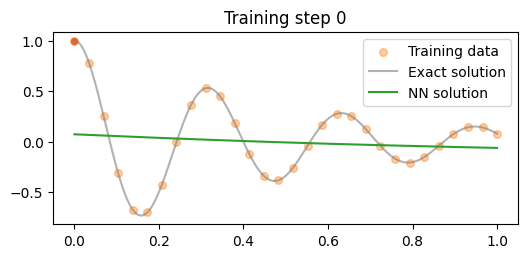

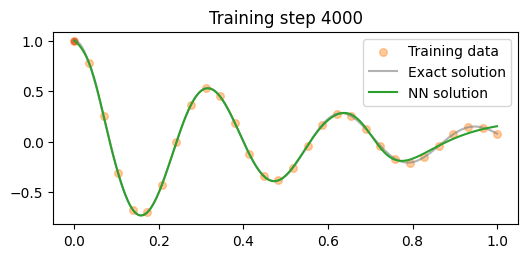

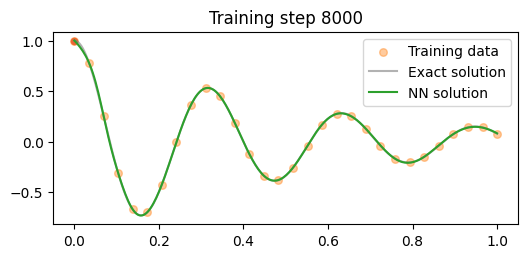

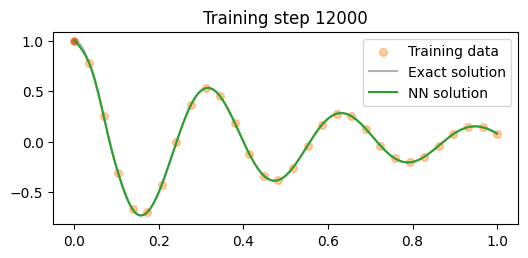

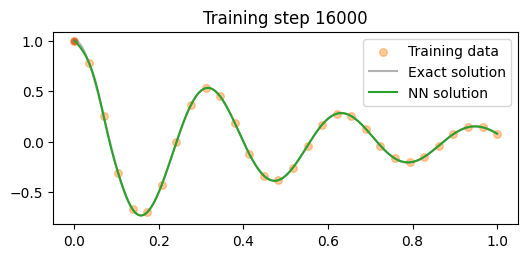

In [5]:
torch.manual_seed(123)

# define a neural network to train
my_nn = FCN(1,1,32,3).to(device)
optimiser = torch.optim.Adam(my_nn.parameters(),lr=1e-3)

t_inference = t_exact.to(device)

# define 30 training points over the entire time domain [0,1]
t_data = torch.linspace(0,1,30).view(-1,1).requires_grad_(True).to(device)# (30, 1)

# prepare some reference data
u_data = exact_solution(d, w0, t_data.detach()).to(device)

def get_data_loss(t):
    # compute data loss
    u_pred = my_nn(t)# (30, 1)
    loss4 = torch.mean((u_pred - u_data)**2) # the loss is based on the data
    return loss4

for i in range(16001):
    optimiser.zero_grad()

    loss = get_data_loss(t_data)
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 4000 == 0:
        make_plot(t_data_locations = t_data.detach().cpu().numpy(),
            u_pred_at_data_locations = u_data.detach().cpu().numpy(),
            u_pred = my_nn(t_inference).detach().cpu().numpy(),
            label_text = 'Training data',
            label_title = f"Training step {i}")

## Task 1: train a PINN to simulate the system

<div class="alert alert-block alert-success"> Notice, that we DO NOT need any reference data except of IC. </div>

#### Task

The first task is to use the PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx u(t)~,
$$


#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2
$$

The first and the second terms correspond to the position of the body and its velocity.
The third term is the governing ODE.

#### Nomenclature

The points at which the physical loss is evaluated are called **collocation points**.

#### Computing gradients

We can calculate the derivatives of the network solution with respect to its input variable at the training points using  autodifferentiation feature of `torch.autograd.grad`, and can then easily compute the residual of the differential equation using these quantities.


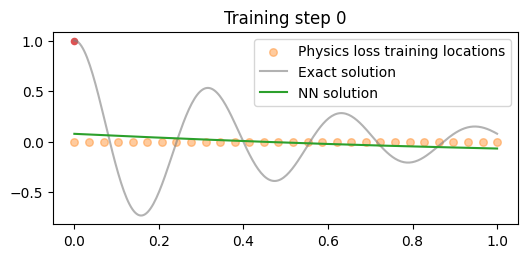

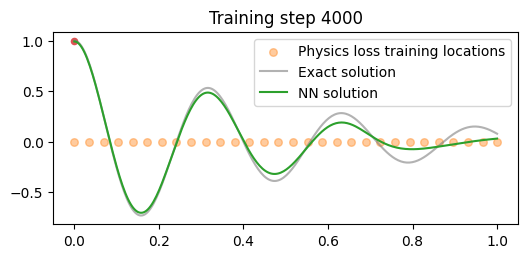

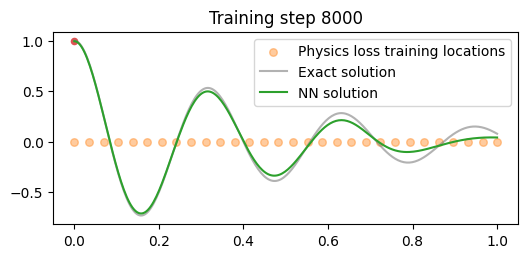

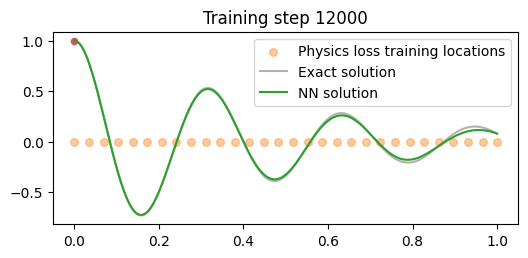

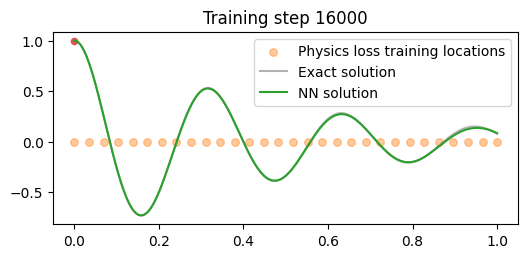

In [6]:
torch.manual_seed(123)

# define a neural network to train
my_pinn = FCN(1,1,32,3).to(device)
optimiser = torch.optim.Adam(my_nn.parameters(),lr=1e-3)

# define collocation points over the entire domain
t_collocation = torch.linspace(0,1,30).view(-1,1).requires_grad_(True).to(device)# (30, 1)

# define boundary points, for the boundary loss (IC)
t_boundary = t_collocation[0].to(device)  # torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)


def get_pde_loss(t, t0):
    # compute each term of the PINN loss function above

    # compute boundary loss, i.e. IC for u(t) and du/dt
    u = my_pinn(t0)# (1, 1)
    loss1 = (torch.squeeze(u) - 1)**2

    dudt = torch.autograd.grad(u, t0, torch.ones_like(u), create_graph=True)[0]# (1, 1)
    loss2 = (torch.squeeze(dudt) - 0)**2

    # my_nn physics loss
    u = my_pinn(t)# (30, 1)
    dudt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    d2udt2 = torch.autograd.grad(dudt, t, torch.ones_like(dudt), create_graph=True)[0]# (30, 1)
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2) # use pde

    # backpropagate joint loss
    # using the following hyperparameters
    lambda1, lambda2 = 1e-1, 1e-4
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    return loss


for i in range(16001):
    optimiser.zero_grad()

    loss = get_pde_loss(t_collocation, t_boundary)

    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 4000 == 0:
        make_plot(t_collocation = t_collocation.detach().cpu().numpy()[:,0],
                  u_collocation = torch.zeros_like(t_collocation).cpu().numpy()[:,0],
                  u_predicted = my_pinn(t_inference).detach().cpu().numpy(),
                  label_text = 'Physics loss training locations',
                  label_title = f"Training step {i}")


## Remarks:

- If you chose 25 collocation points in the PINN example, you have to adjust weight in the ODE loss function for proper training.
- You may split the data into training and test set to make sure that NN does not converge towards trivial solution.
- The collocation points can be resampled/shuffled between batches.
- Notice, that an **unlucky** sampling may fit into zeros of the sinusoidal signal. Therefore it is recommended to use random sampling instead of regular one.

## Questions:

- Why the coefficient for ODE loss is so small compared to the IC loss?

- What happens beyond the training set? Did the PINN really learned the underlying ODE?

Let's extrapolate beyond the training set.
Reminder: the training has been done for t in [0,1], we will check the [0,2] range.

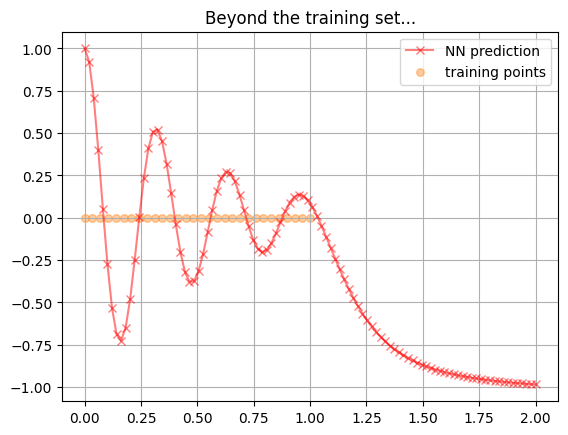

In [7]:
my_t = torch.linspace(0,2,100).view(-1,1).requires_grad_(True).to(device)# (30, 1)
my_u = my_nn(my_t)
plt.plot(my_t[:,0].detach().cpu().numpy(), my_u[:,0].detach().cpu().numpy(), 'r-x', alpha=0.5, label="NN prediction")
plt.scatter(t_training.detach().cpu().numpy()[:,0], torch.zeros_like(t_training).cpu().numpy()[:,0], s=30, color="tab:orange", alpha=0.4, label='training points')
plt.title("Beyond the training set...")
plt.grid()
plt.legend()
plt.show()

## What can we use PINN for?

If the experimental data are sparse (like have recorded / simulated just a part of the motion), then addtional *physics loss training locations* can be added to improve/extend the prediction range.